This notebook takes in the glims database as input and outputs a processed version of the database ready for earth engine consumption

In [16]:
import os
import geopandas as gpd
import pandas as pd
from collections import Counter
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

In [11]:
glacier_view_dir = os.path.join(os.path.expanduser("~"), "Desktop","projects","GlacierView")
glims_path = os.path.join(glacier_view_dir,"src","glims","data","glims_db_20210914","glims_polygons.shp")
df = gpd.read_file(glims_path, index_col = 0) 

In [45]:
df['date'] = [datetime.strptime(dat.split("T")[0], '%Y-%m-%d') for dat in list(df.src_date)] #convert string dates to datetime

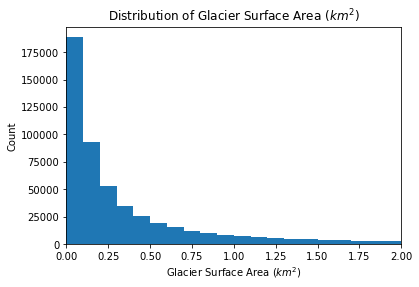

In [33]:
plt.hist(df.db_area, bins = np.arange(0,50,0.1))
plt.xlim(0,2)
plt.xlabel("Glacier Surface Area ($km^2$)")
plt.ylabel("Count")
plt.title("Distribution of Glacier Surface Area ($km^2$)")
plt.show()

In [43]:
df[['glac_id','geog_area']].groupby('geog_area').glac_id.nunique().to_csv("glaciers_per_geog_area.csv")

In [46]:
df = df.loc[df['date'] > datetime(2005,1,1)] #select glaciers with polygons drawn after 2005
print(f"Unique glaciers: {len(pd.unique(df.glac_id))}")
df = df[~df['geog_area'].isin(['Svalbard, Jan Mayen, and Bouvet', "Various (GlobGlacier)", 'Randolph Glacier Inventory; Umbrella RC for merging the RGI into GLIMS','Antarctic Peninsula','Various (NSIDC)'])]
print(f"Unique glaciers: {len(pd.unique(df.glac_id))}")
df = df[(df.db_area > 1) & (df.db_area < 50)] #nothing too small, nothing too large
print(f"Unique glaciers: {len(pd.unique(df.glac_id))}")
df = df.iloc[:,:-1] #ESRI shapefiles don't support datetime fields 

Unique glaciers: 170363
Unique glaciers: 122212
Unique glaciers: 18093


In [7]:
#remove glac ids which appear more than once in GLIMS (multiple annotations)
df = df.reset_index(drop = True)
clean_copy = df.copy()
s = set()
for i in range(df.shape[0]):
    if df.glac_id[i] in s:
        clean_copy = clean_copy.drop(i, axis = 0)
    else:
        s.add(df.glac_id[i])
df = clean_copy

In [8]:
ids = list(Counter(df.glac_id).keys()) #get list of unique ids
#df['geometry'] = gpd.GeoSeries.from_wkt(df['geometry']) not needed anymore
gdf = gpd.GeoDataFrame(df, geometry = "geometry")

In [9]:
bboxes = []
for i in range(df.shape[0]):
    bboxes.append(list(zip(*np.asarray(gdf.iloc[[i],:].envelope.scale(xfact = 1.1, yfact = 1.1).squeeze().exterior.coords.xy))))
gdf['bboxes'] = [str(bbox) for bbox in bboxes]

In [11]:
gdf.to_file(os.path.join(glacier_view_dir,"src","glims","data","training_sample","glims_18k_bb.shp"))